In [5]:
import pandas as pd

In [6]:
from os import listdir

In [7]:
import numpy as np

In [8]:
import seaborn as sns

In [9]:
import matplotlib.pyplot as plt

In [10]:
def load_file(file_name):
    id_polvo = file_name.split('.')[0][1]
    data = '-'.join(file_name.split('-')[0].split('.')[1:4])
    dataset = pd.read_csv(f'data/{file_name}', sep=';', header=None, names=['estado', 'inicio', 'fim'])
    dataset['inicio'] = pd.to_datetime(dataset['inicio'].str.strip(), format='%H:%M:%S')
    dataset['fim'] = pd.to_datetime(dataset['fim'].str.strip(), format='%H:%M:%S')
    dataset['duracao'] = (dataset['fim'] - dataset['inicio']).astype(np.int64) / (60 * (10 ** 9))
    dataset['polvo'] = id_polvo
    dataset['data'] = data
    return dataset

In [11]:
df = pd.concat([load_file(registros) for registros in listdir('data') if 'csv' in registros]).reset_index(drop=True)

In [12]:
df['estado'].unique()

array(['Alert', 'Active', 'QOP', 'REM-like', 'SWS-like', 'QHH',
       '00:00:14', 'QCP', 'OEM', 'REM-likeE', 'QPCN'], dtype=object)

In [13]:
sws_vizinha_de_rem = []
rem_vizinho_de_sws = []
U = []
V = []
linha_anterior = None
for i, row in df.iterrows():
    if i == 0:
        linha_anterior = row
        continue
    elif 'REM' in row['estado'] and 'SWS' in linha_anterior['estado']:
        sws_vizinha_de_rem.append(linha_anterior)
        rem_vizinho_de_sws.append(row)
        U.append(pd.Series({'SWS': linha_anterior['duracao'], 'REM': row['duracao']}))

    linha_anterior = row

In [14]:
U = pd.DataFrame(U)

In [15]:
U.shape

(88, 2)

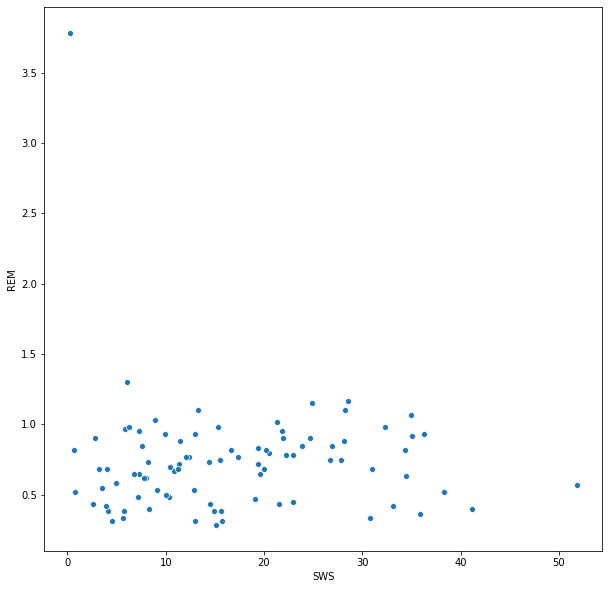

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(x='SWS', y='REM', data=U)

# SWS que vem antes do REM

In [17]:
V = pd.DataFrame(rem_vizinho_de_sws)

In [18]:
V.head()

,estado,inicio,fim,duracao,polvo,data
25,REM-like,1900-01-01 08:21:48,1900-01-01 08:22:20,0.533333,2,11-04-18
64,REM-like,1900-01-01 07:52:10,1900-01-01 07:52:35,0.416667,2,12-04-18
71,REM-like,1900-01-01 08:46:48,1900-01-01 08:47:10,0.366667,2,12-04-18
88,REM-like,1900-01-01 10:05:19,1900-01-01 10:05:58,0.650000,2,12-04-18
111,REM-like,1900-01-01 11:21:40,1900-01-01 11:22:00,0.333333,2,12-04-18


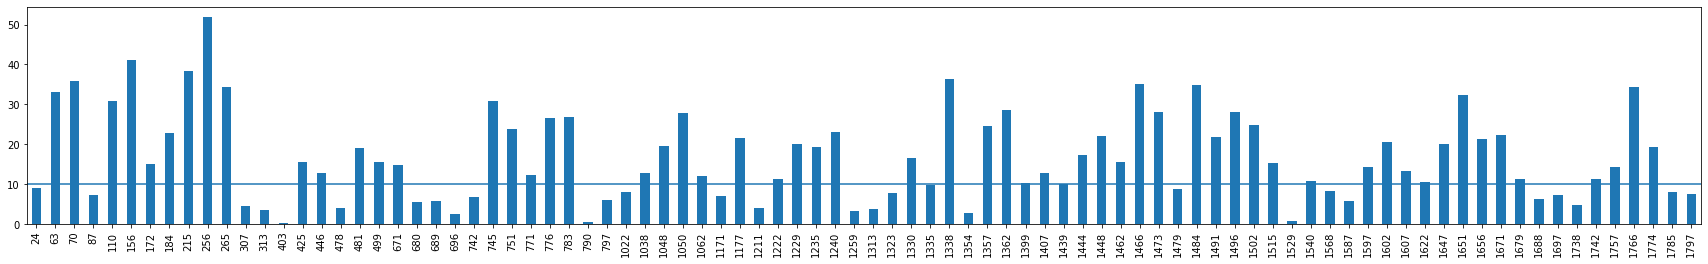

In [19]:
T = pd.DataFrame(sws_vizinha_de_rem)
ax = T['duracao'].plot(kind='bar', figsize=(30, 4));
ax.axhline(10);

In [20]:
T['data'].unique()

array(['11-04-18', '12-04-18', '13-04-18', '14-04-18', '26-07-18',
       '27-07-18', '29-07-18', '20-10-18', '22-10-18', '23-10-18',
       '16-03-18', '18-03-18', '19-03-18', '20-03-18'], dtype=object)

In [21]:
T['class'] = 'SWS'
V['class'] = 'REM'

In [22]:
X = pd.concat([T, V])

In [23]:
X = X.reset_index()

In [24]:
X.head()

,index,estado,inicio,fim,duracao,polvo,data,class
0,24,SWS-like,1900-01-01 08:12:40,1900-01-01 08:21:48,9.133333,2,11-04-18,SWS
1,63,SWS-like,1900-01-01 07:19:00,1900-01-01 07:52:10,33.166667,2,12-04-18,SWS
2,70,SWS-like,1900-01-01 08:10:55,1900-01-01 08:46:48,35.883333,2,12-04-18,SWS
3,87,SWS-like,1900-01-01 09:58:00,1900-01-01 10:05:19,7.316667,2,12-04-18,SWS
4,110,SWS-like,1900-01-01 10:50:55,1900-01-01 11:21:40,30.750000,2,12-04-18,SWS


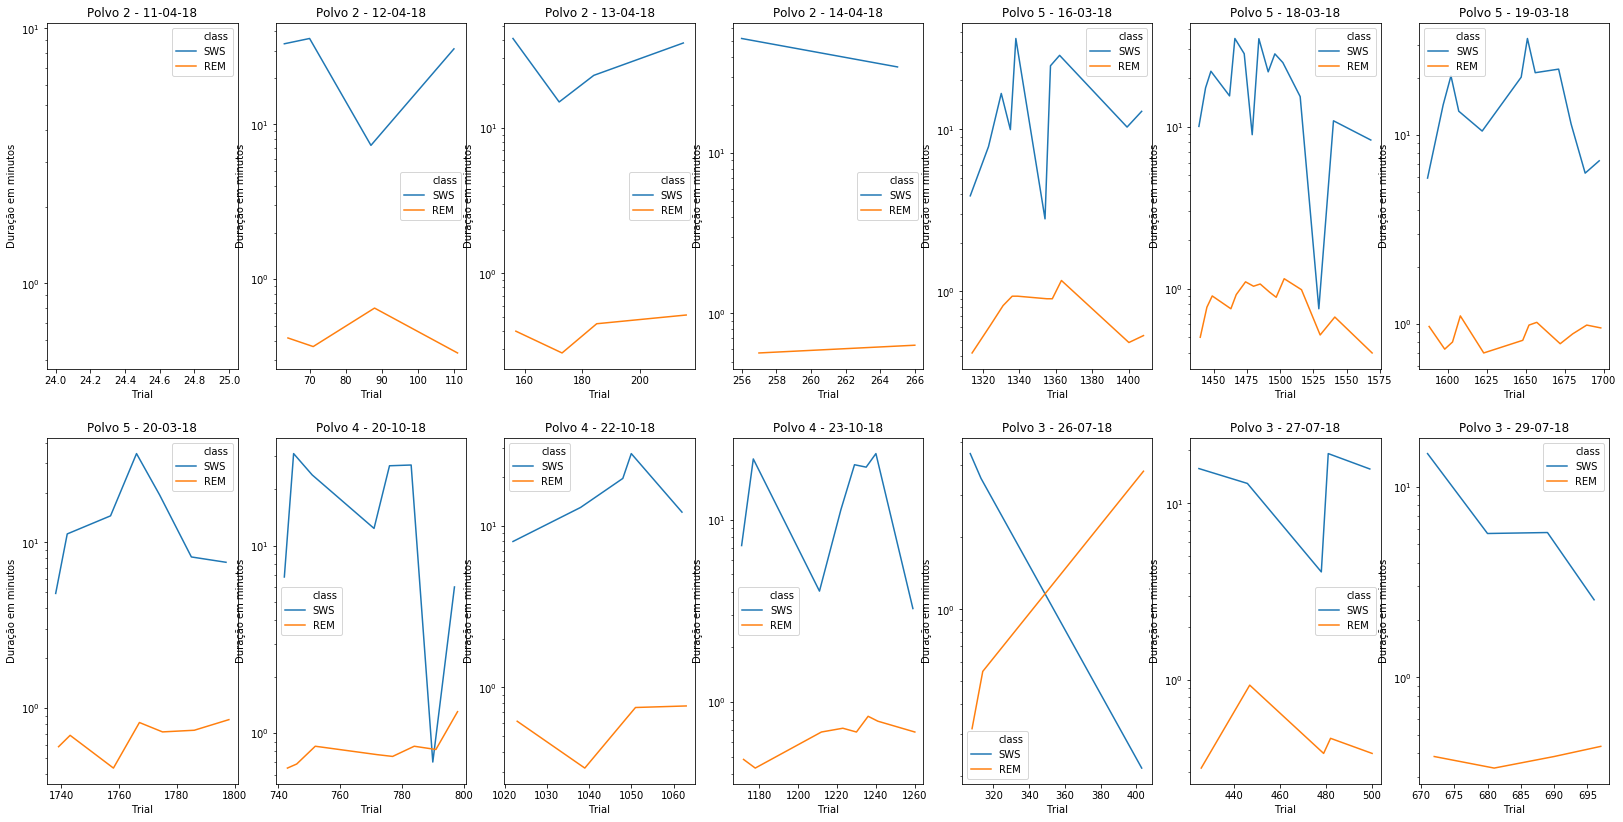

In [25]:
fig, axs = plt.subplots(nrows=2, ncols=7, figsize=(28, 14))
# print(axs.shape)
j = 0
k = 0

for G in X.groupby('data'):
    sns.lineplot(data=G[1], x='index', y='duracao', hue='class', ax=axs[j][k]);
    data = G[1]['data'].unique()[0]
    polvo = G[1]['polvo'].unique()[0]
    axs[j][k].set_title(f'Polvo {polvo} - {data}');
    axs[j][k].set(yscale="log");
    axs[j][k].set_xlabel('Trial');
    axs[j][k].set_ylabel('Duração em minutos');
    k += 1
    if k == axs.shape[1]:
        k = 0
        j += 1

In [26]:
T.shape

(88, 7)

## SWS antes do REM com menos de 7min

In [101]:
T[T['duracao'] < 7].shape

(18, 6)

In [28]:
18 / 88

0.20454545454545456

## SWS antes do REM com 7min ou mais

In [29]:
T[T['duracao'] >= 7].shape

(70, 7)

# Todos os SWS

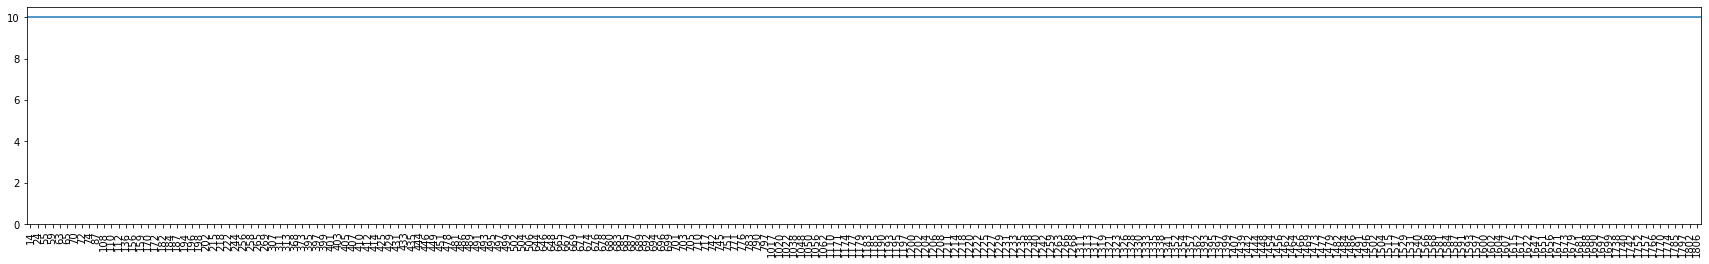

In [30]:
s = df.loc[df['estado'] == 'SWS-like', 'duracao'] # .astype(np.int64) # .plot(kind='bar')
ax = ((s / 10**9) / 60).plot(kind='bar', figsize=(30, 4));
ax.axhline(10);

In [31]:
S = ((s / 10**9) / 60)

# SWS com menos de 10min

In [100]:
sws_all = S.shape
print(sws_all)
sws_less_5 = S[S < 5].shape
sws_less_7 = S[S < 7].shape
sws_less_10 = S[S < 10].shape
sws_less_20 = S[S < 20].shape

print(sws_less_5)
print((str((sws_less_5[0]/sws_all[0])*100))+'%')
print((str((sws_less_7[0]/sws_all[0])*100))+'%')
print((str((sws_less_10[0]/sws_all[0])*100))+'%')
print((str((sws_less_20[0]/sws_all[0])*100))+'%')



(228,)
(228,)
100.0%
100.0%
100.0%
100.0%


In [33]:
108 / (108 + 120)

0.47368421052631576

# SWS com 10min ou mais

In [34]:
S[S >= 7].shape

(0,)